In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Import session

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tqdm
import tqdm.notebook as tqdm
from torch.nn.utils import clip_grad_norm_
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import textwrap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report


# Prepare Data

In [3]:
train_df = pd.read_csv('./data/allergens_train.csv')
val_df = pd.read_csv('./data/allergens_val.csv')
test_df = pd.read_csv('./data/allergens_test.csv')
columns_to_drop = ['target', 'class_id']
train_df = train_df.drop(columns_to_drop, axis=1)
val_df = val_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
allergens = train_df.columns[4:]
train_df

path class_name  \
0      ../archive/images/apple_pie/1005649.jpg  apple_pie   
1      ../archive/images/apple_pie/1014775.jpg  apple_pie   
2      ../archive/images/apple_pie/1026328.jpg  apple_pie   
3      ../archive/images/apple_pie/1028787.jpg  apple_pie   
4      ../archive/images/apple_pie/1043283.jpg  apple_pie   
...                                        ...        ...   
68170     ../archive/images/waffles/981485.jpg    waffles   
68171      ../archive/images/waffles/98238.jpg    waffles   
68172     ../archive/images/waffles/982668.jpg    waffles   
68173     ../archive/images/waffles/995085.jpg    waffles   
68174     ../archive/images/waffles/999047.jpg    waffles   

                                             ingredients  \
0      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
1      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
2      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
3      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
4      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
...                                                  ...   
68170  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68171  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68172  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68173  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68174  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   

                                 allergens  sugar  apple  butter  lemon  \
0             ['sugar', 'apple', 'butter']      1      1       1      0   
1             ['sugar', 'apple', 'butter']      1      1       1      0   
2             ['sugar', 'apple', 'butter']      1      1       1      0   
3             ['sugar', 'apple', 'butter']      1      1       1      0   
4             ['sugar', 'apple', 'butter']      1      1       1      0   
...                                    ...    ...    ...     ...    ...   
68170  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68171  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68172  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68173  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68174  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   

       honey  sweet pepper  ...  sweet potato  potato  celery  rice  cherry  \
0          0             0  ...             0       0       0     0       0   
1          0             0  ...             0       0       0     0       0   
2          0             0  ...             0       0       0     0       0   
3          0             0  ...             0       0       0     0       0   
4          0             0  ...             0       0       0     0       0   
...      ...           ...  ...           ...     ...     ...   ...     ...   
68170      0             0  ...             0       0       0     0       0   
68171      0             0  ...             0       0       0     0       0   
68172      0             0  ...             0       0       0     0       0   
68173      0             0  ...             0       0       0     0       0   
68174      0             0  ...             0       0       0     0       0   

       salmon  cabbage  duck  orange  strawberry  
0           0        0     0       0           0  
1           0        0     0       0           0  
2           0        0     0       0           0  
3           0        0     0       0           0  
4           0        0     0       0           0  
...       ...      ...   ...     ...         ...  
68170       0        0     0       0           0  
68171       0        0     0       0           0  
68172       0        0     0       0           0  
68173       0        0     0       0           0  
68174       0        0     0       0           0  

[68175 rows x 37 columns]

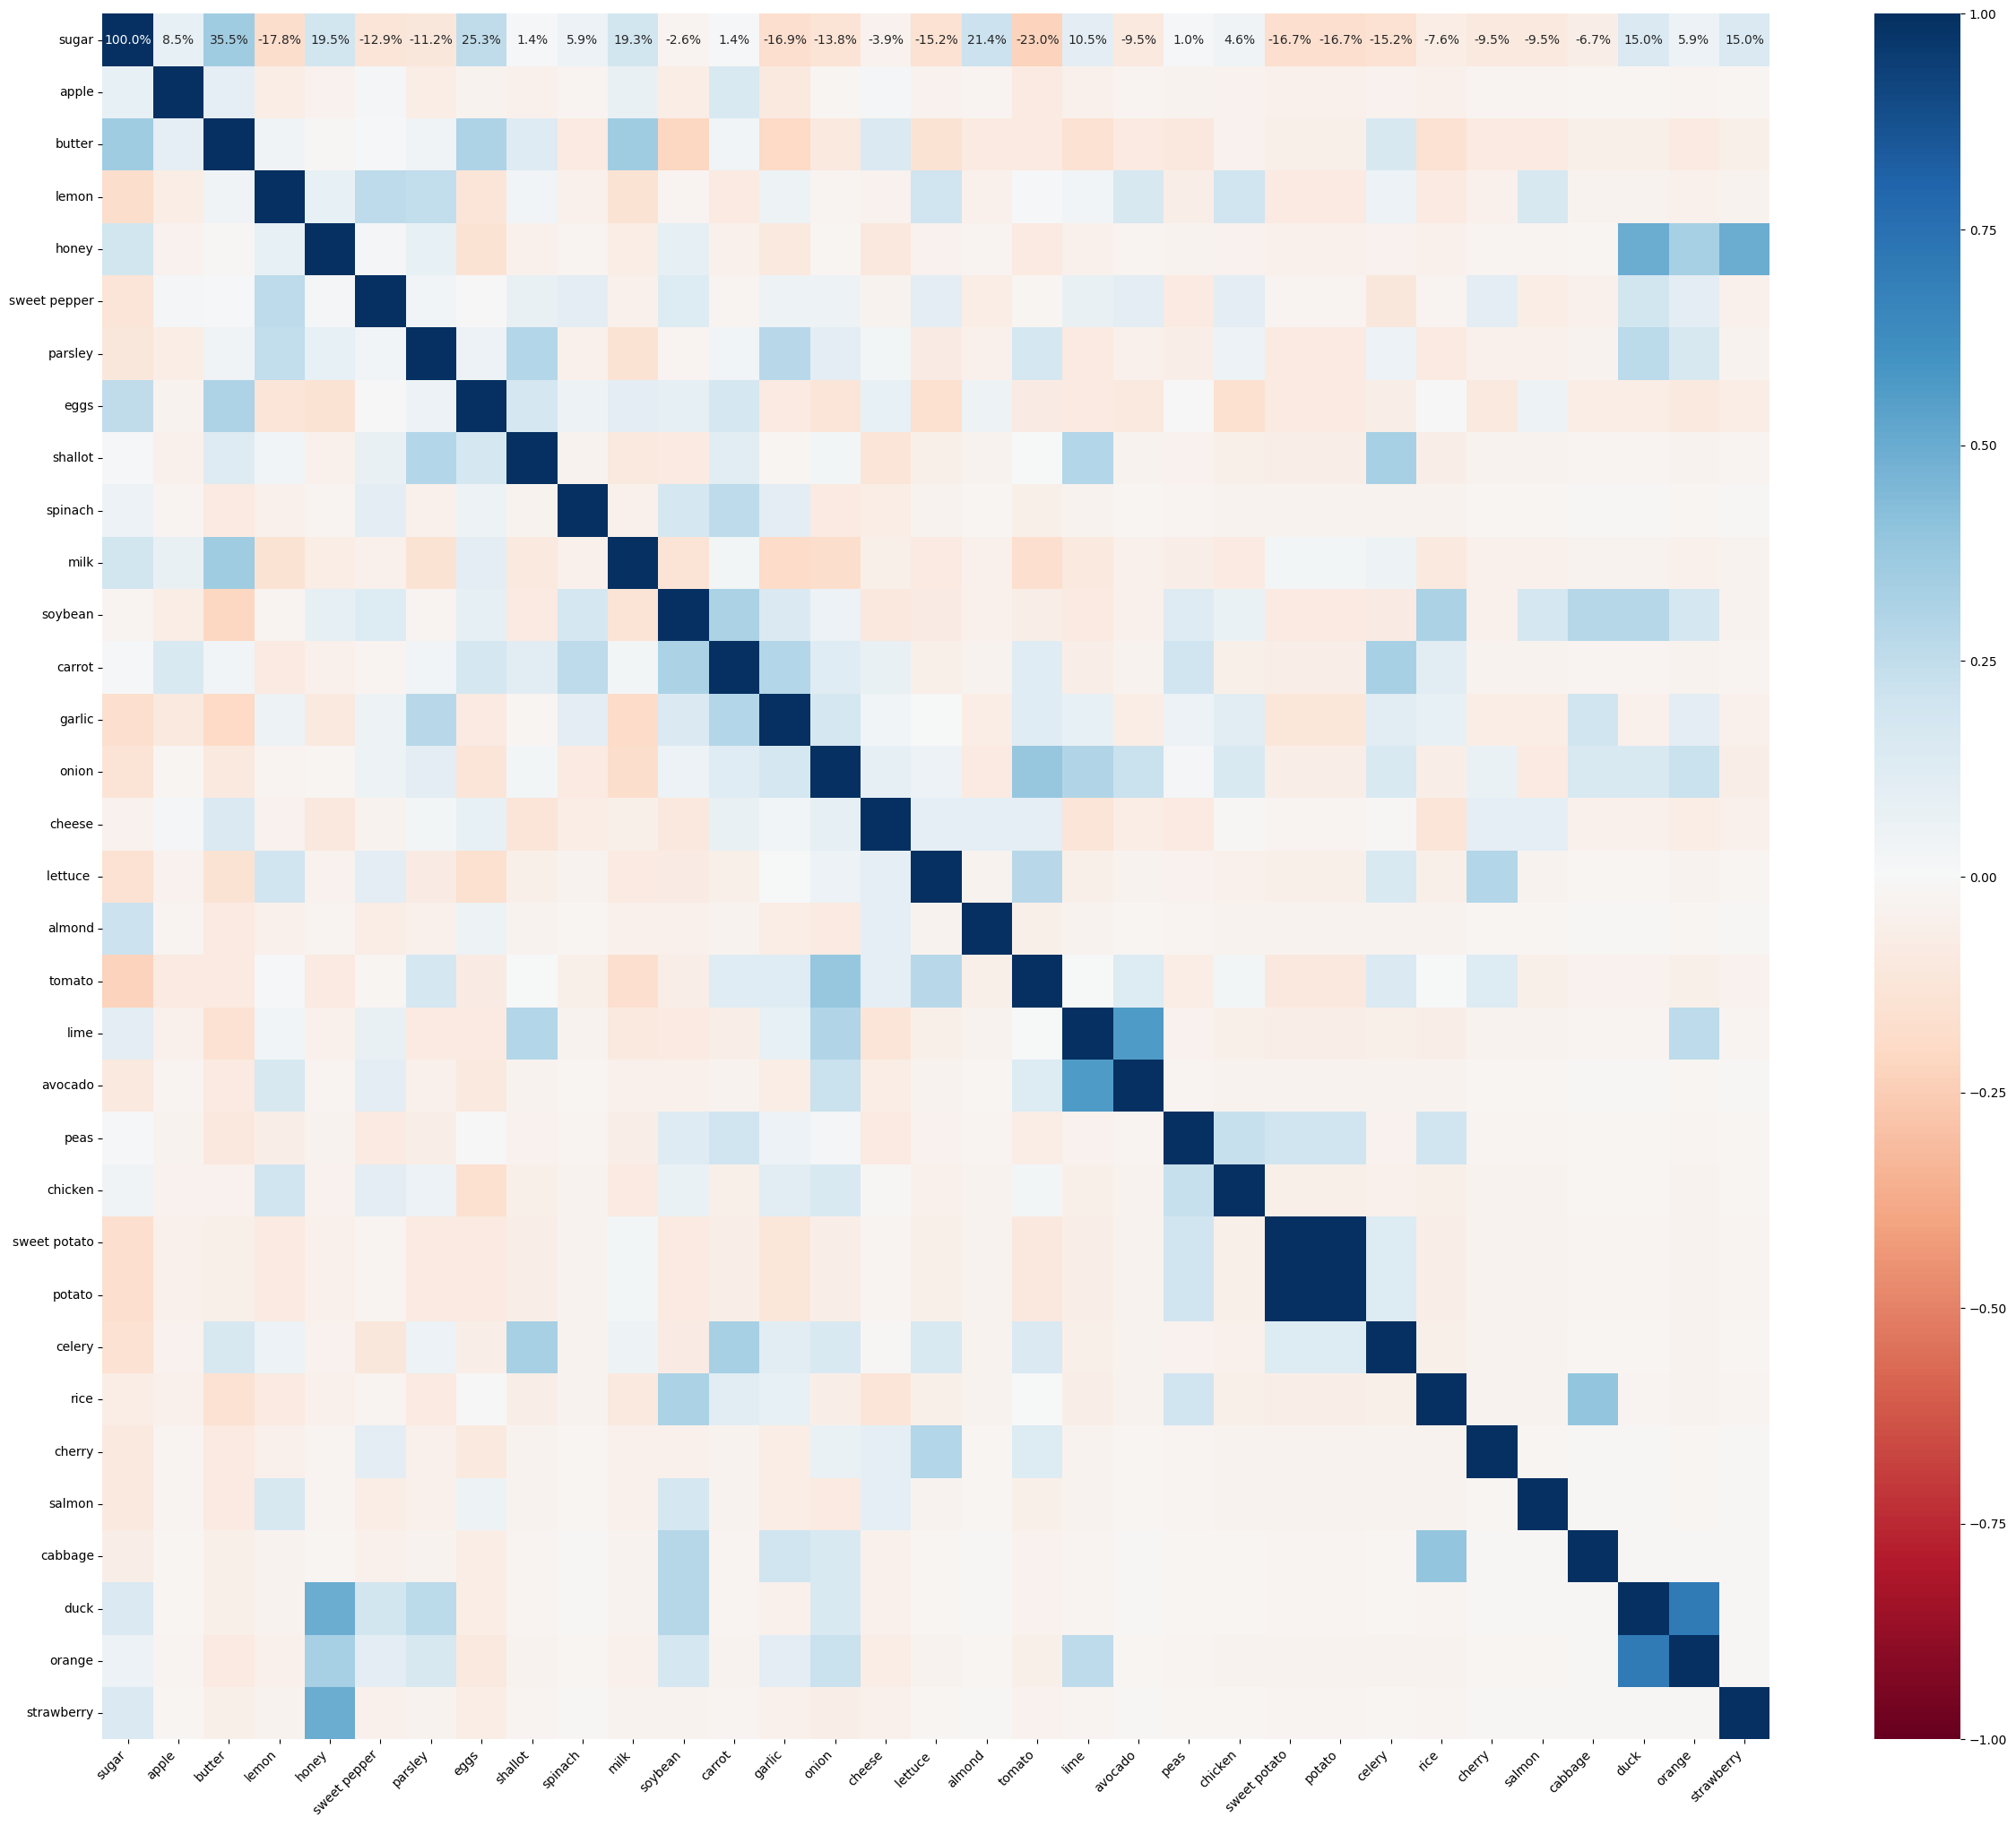

In [4]:
mapped_data = train_df[allergens].apply(lambda x: x.map(lambda val: 1 if val > 0 else 0)).values
mapped_data = mapped_data.T
co_all = np.corrcoef(mapped_data)

fig, ax1 = plt.subplots(1, 1, figsize=(30, 25))
heatmap = sns.heatmap(co_all, annot=True, fmt='2.1%', ax=ax1, cmap='RdBu', vmin=-1, vmax=1)

ax1.set_xticklabels(allergens, rotation=45, ha='right')
ax1.set_yticklabels(allergens, rotation=0, ha='right')
plt.show()


# Manual Resample

In [5]:
# column_sums = train_df[train_df.columns[6:]].sum()
# sorted_columns = column_sums.sort_values(ascending=True).index
# alleg_df = train_df[train_df.columns[:6].tolist() + sorted_columns.tolist()]
# columns_to_move = ["strawberry", "duck", "cabbage", "avocado", "almond", "orange"]
# remaining_columns = [col for col in alleg_df.columns if col not in columns_to_move]
# desired_column_order = remaining_columns[:6] + columns_to_move + remaining_columns[6:]
# alleg_df = alleg_df[desired_column_order]

# labels = alleg_df.columns[6:]
# label_counts = alleg_df[labels].sum()
# plt.figure(figsize=(12, 6))
# label_counts.plot(kind='bar', color='skyblue')
# plt.title('Label Distribution')
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.show()
# print(label_counts)

In [6]:
# from sklearn.utils import resample
# selected_columns = alleg_df.columns[-3:]
# other_df = alleg_df[(alleg_df[selected_columns] == 1).any(axis=1)]
# oversample_df = alleg_df[(alleg_df[selected_columns] == 0).all(axis=1)]

# selected_columns = alleg_df.columns[6:-3]
# temp_df = pd.DataFrame(columns=alleg_df.columns)
# upsampled = []
# skip_label = []
# for k in selected_columns:
#     df = oversample_df[oversample_df[k] == 1]
#     total_count = df[k].sum()

#     removed_sample = total_count + temp_df[k].sum() + other_df[k].sum()
#     original_threshold = 30000
#     threshold = original_threshold-removed_sample
#     # print(k, total_count, temp_df[k].sum(), removed_sample, threshold)
#     if not df.empty and threshold > 0:
#         fraud_upsampled = resample(df[df[k] == 1],
#                                    replace=True,
#                                    n_samples=threshold,
#                                    random_state=27)
#         fraud_upsampled = pd.DataFrame(fraud_upsampled, columns=df.columns)
#         temp_df = pd.concat([temp_df, fraud_upsampled])
#         issue_column = []
#         for i in temp_df.columns[6:]:
#             label_counts_df1 = temp_df[i].sum()
#             label_counts_df2 = other_df[i].sum()
#             if label_counts_df1 + label_counts_df2 >= original_threshold:
#                 issue_column.append(i)
#         if len(issue_column) > 0:
#             fraud_upsampled = resample(df[df[k].eq(1)],
#                                         replace=True,
#                                         n_samples=10000,
#                                         random_state=27)
#             fraud_upsampled = pd.DataFrame(fraud_upsampled, columns=df.columns)
                
#             temp_df = pd.concat([temp_df, fraud_upsampled])
#             label_counts = temp_df[temp_df.columns[6:]].sum()
#             check_label = label_counts[label_counts >= 30000]
#             check_column = []
#             for i in check_label.index.tolist():
#                 if i not in skip_label:
#                     check_column.append(i)
#                     skip_label.append(i)
#             if len(check_column) < 4:
#                 print(k, check_column)
#                 upsampled.append(fraud_upsampled)
#                 # df_when_col3_is_0 = df_when_col3_is_0[(df_when_col3_is_0[issue_column] == 0).any(axis=1)]
#         else:
#             upsampled.append(fraud_upsampled)
#         issue_column=[]
#         oversample_df = oversample_df[oversample_df[k] == 0]
# upsampled_df = pd.concat([other_df] + upsampled)

# labels = upsampled_df.columns[6:]
# label_counts = upsampled_df[labels].sum()
# plt.figure(figsize=(12, 6))
# label_counts.plot(kind='bar', color='skyblue')
# plt.title('Label Distribution')
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.show()
# print(label_counts)
# print(label_counts.max())

In [7]:
# missing = []
# for label in alleg_df.columns[6:]:
#     if label_counts[label] < 8000:
#         missing.append(label)
# missing

In [8]:
# def missing_label(column):
#     index = upsampled_df.columns.get_loc(column)
#     keep_df = upsampled_df[(upsampled_df[column] == 0)]
#     fraud_df = upsampled_df[(upsampled_df[column] == 1)]
#     selected_columns = upsampled_df.columns[index:-3]
#     missing_df = fraud_df[(fraud_df[selected_columns] == 0).any(axis=1)]

#     upsampled = []
#     selected_columns = upsampled_df.columns[index:-3]
#     for k in selected_columns:
#         df = missing_df[missing_df[k] == 1]
#         if not df.empty:
#             fraud_upsampled = resample(df,
#                                         replace=True,
#                                         n_samples=8000,
#                                         random_state=27)
#             fraud_upsampled = pd.DataFrame(fraud_upsampled, columns=df.columns)
#             upsampled.append(fraud_upsampled)
#             missing_df = missing_df[missing_df[k] == 0]
#     return pd.concat([keep_df] + upsampled)

# for column in missing:
#     upsampled_df = missing_label(column)

# labels = upsampled_df.columns[6:]
# label_counts = upsampled_df[labels].sum()
# plt.figure(figsize=(12, 6))
# label_counts.plot(kind='bar', color='skyblue')
# plt.title('Label Distribution')
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.show()
# print(label_counts)
# print(label_counts.max())

# Resample All < 10000

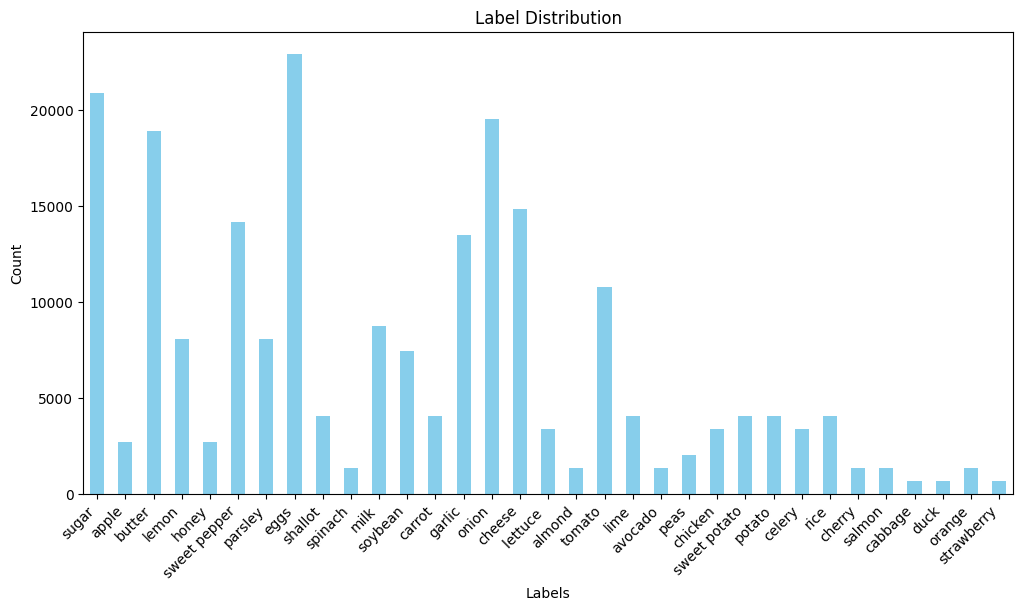

sugar           20925
apple            2700
butter          18900
lemon            8100
honey            2700
sweet pepper    14175
parsley          8100
eggs            22950
shallot          4050
spinach          1350
milk             8775
soybean          7425
carrot           4050
garlic          13500
onion           19575
cheese          14850
lettuce          3375
almond           1350
tomato          10800
lime             4050
avocado          1350
peas             2025
chicken          3375
sweet potato     4050
potato           4050
celery           3375
rice             4050
cherry           1350
salmon           1350
cabbage           675
duck              675
orange           1350
strawberry        675
dtype: int64
22950


In [9]:
label_counts = train_df[allergens].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print(label_counts)
print(label_counts.max())

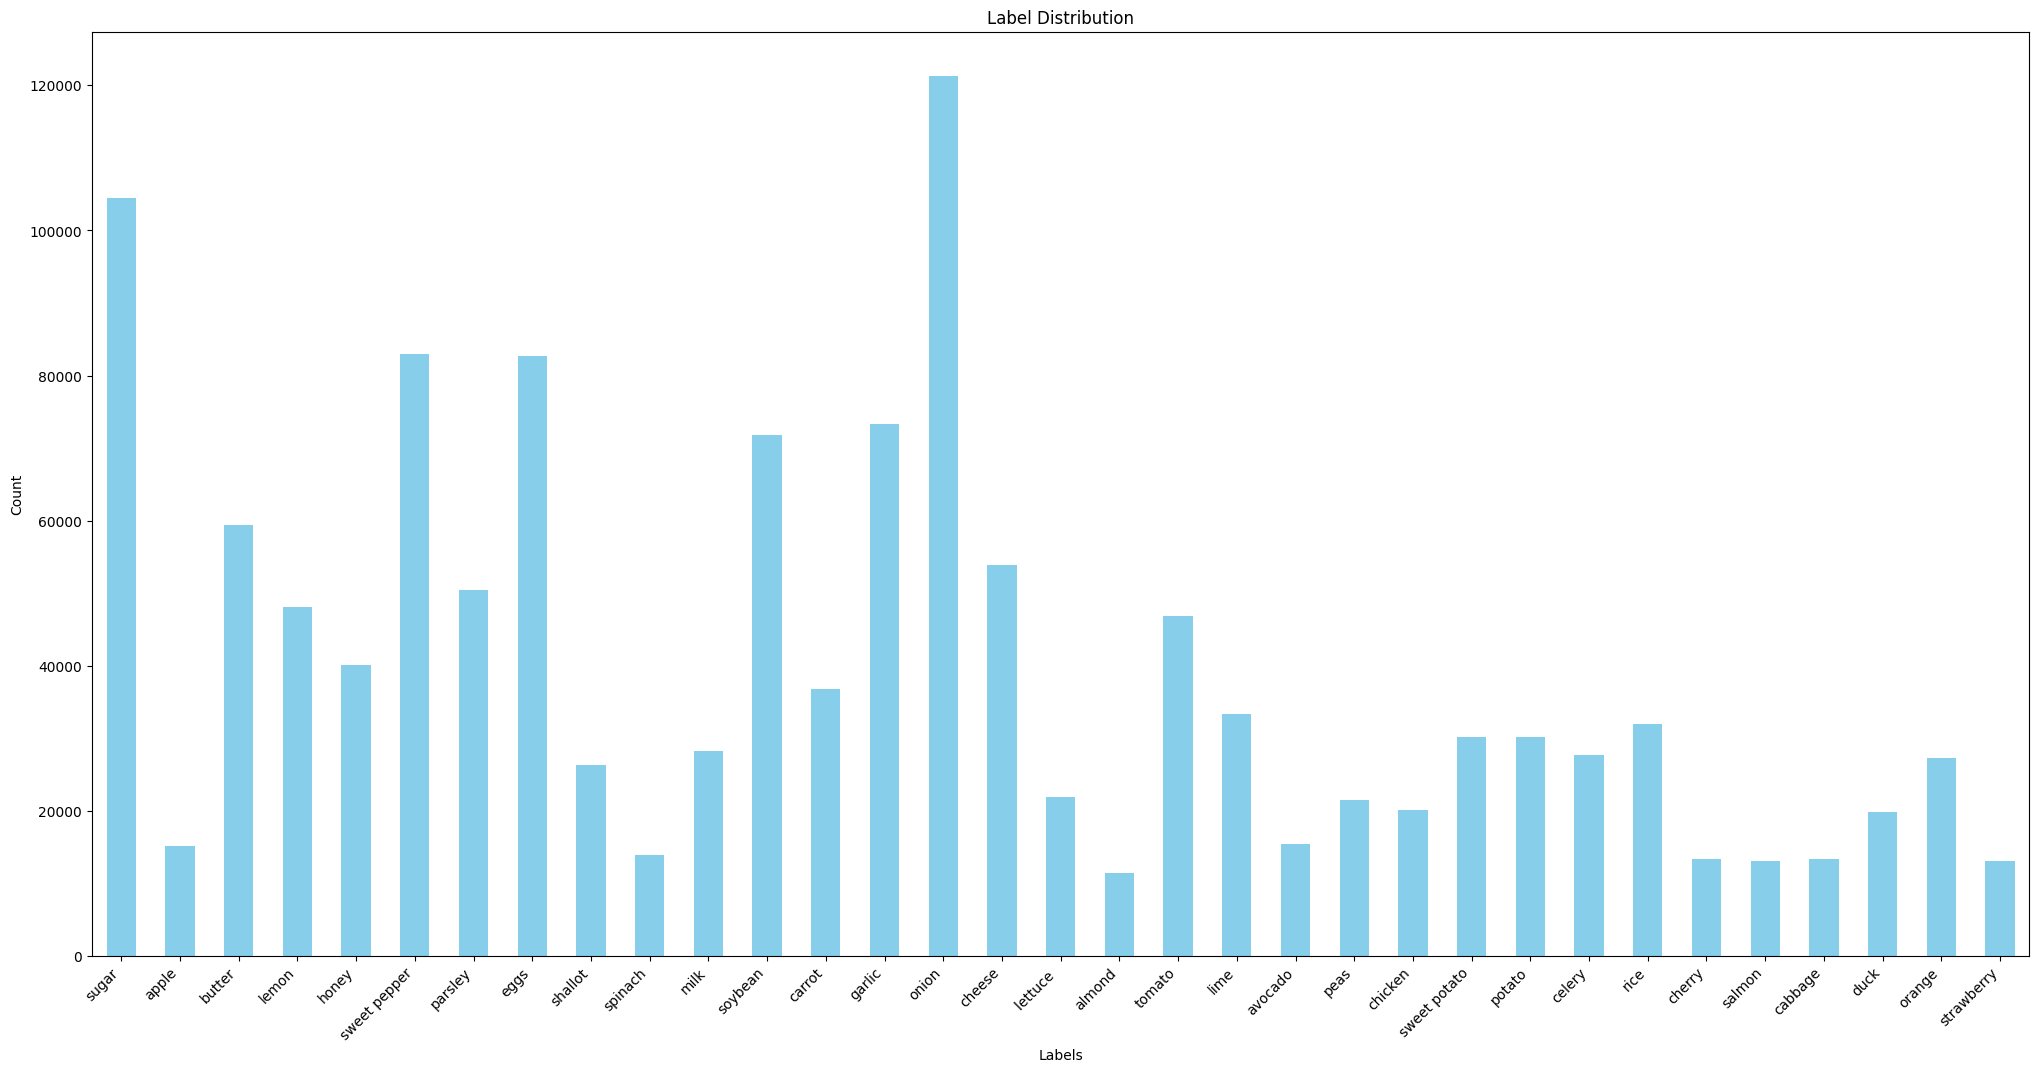

sugar           104444
apple            15135
butter           59423
lemon            48074
honey            40114
sweet pepper     82972
parsley          50378
eggs             82698
shallot          26311
spinach          13861
milk             28182
soybean          71841
carrot           36733
garlic           73300
onion           121324
cheese           53853
lettuce          21898
almond           11350
tomato           46884
lime             33390
avocado          15485
peas             21508
chicken          20062
sweet potato     30103
potato           30103
celery           27719
rice             31894
cherry           13356
salmon           13083
cabbage          13299
duck             19808
orange           27315
strawberry       13120
dtype: int64


In [10]:
labels = train_df.columns[4:]
label_counts = train_df[labels].sum()
threshold = 10000
labels_to_upsample = label_counts[label_counts < threshold].index.tolist()

upsampled_dataframes = []

resample_train_df = pd.DataFrame(columns=train_df.columns)
for k in labels_to_upsample:
    label_data = train_df[train_df[k] == 1]
    upsampled_label_data = resample(label_data, replace=True, n_samples=threshold, random_state=42)
    upsampled_dataframes.append(upsampled_label_data)

resample_train_df = pd.concat([train_df] + upsampled_dataframes, ignore_index=True)

label_counts = resample_train_df[allergens].sum()
plt.figure(figsize=(25, 12))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print(label_counts)

# Preprocessing data

In [11]:
image_size = (224, 224)

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augmentation=None):
        self.dataframe = dataframe
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = torch.Tensor(self.dataframe.iloc[idx, 4:].values.astype(float))

        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.augmentation:
            image_np = np.array(image)
            augmented_image_np = self.augmentation(images=[image_np])[0]
            image = Image.fromarray(augmented_image_np)

        if self.transform:
            image = self.transform(image)

        image = torch.Tensor(image)
        label = torch.Tensor(label)

        return image, label

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.2, 0.05 * 255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(rotate=(-30, 30)),
])

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=(0.7, 1.3)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.01, scale=(0.9, 1.25))
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(dataframe=train_df, transform=train_transform, augmentation=augmentation)
val_dataset = CustomDataset(dataframe=val_df, transform=test_transform)
test_dataset = CustomDataset(dataframe=test_df, transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


/Users/mac/anaconda3/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


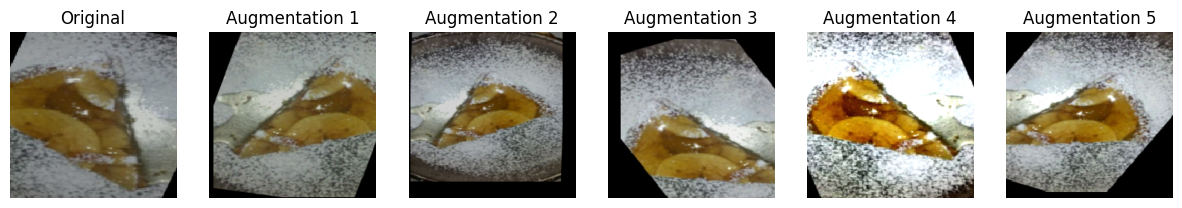

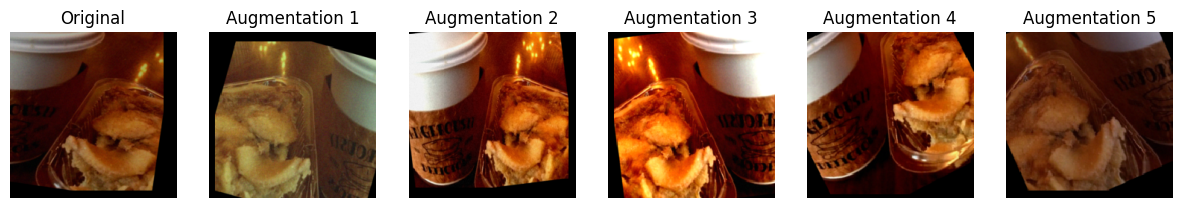

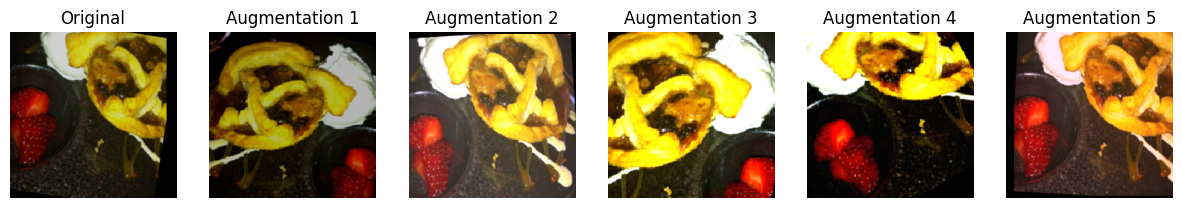

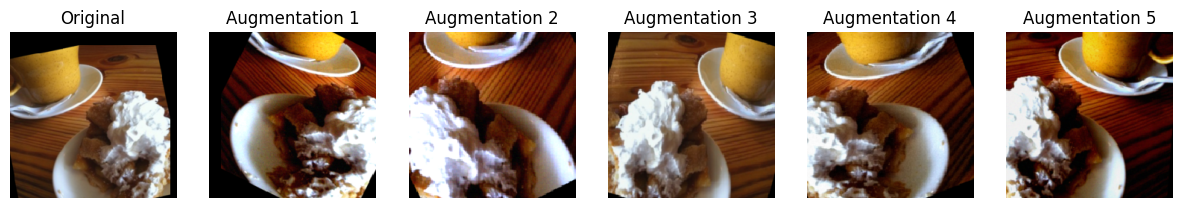

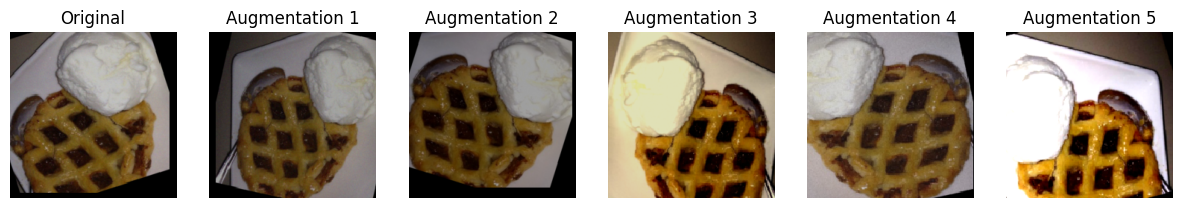

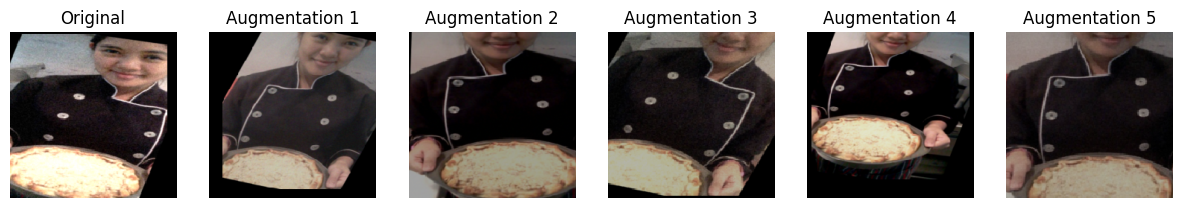

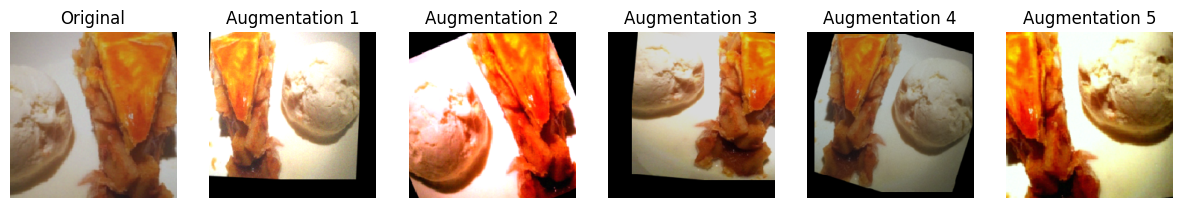

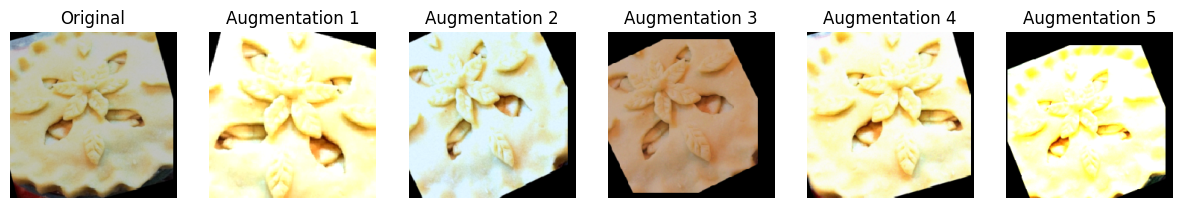

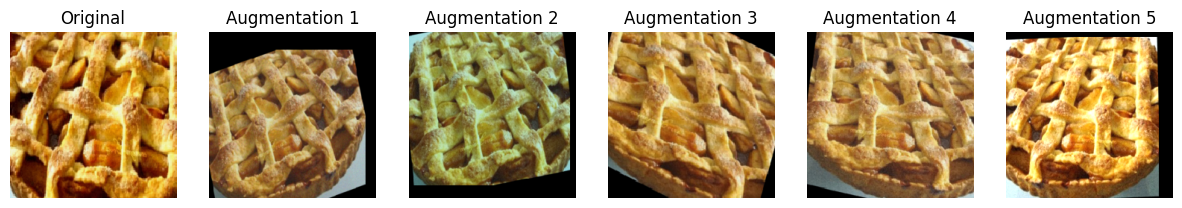

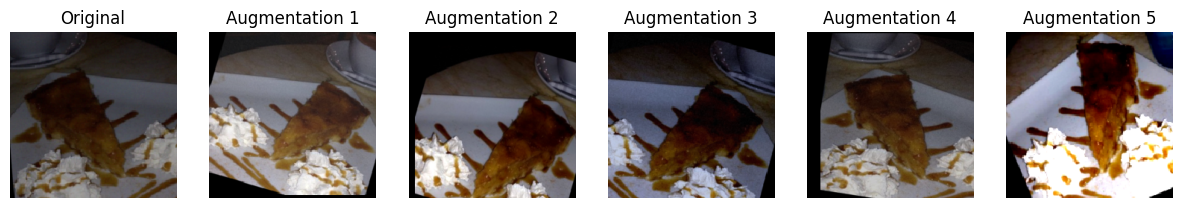

In [12]:
def show_augmentations(dataset, original_idx=0, num_augmentations=5):
    original_img, _ = dataset[original_idx]

    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 3))

    # Display the original image
    axes[0].imshow(np.transpose(original_img.numpy(), (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Original')

    # Display augmentations of the same image
    for i in range(1, num_augmentations + 1):
        augmented_img, _ = dataset[original_idx]
        axes[i].imshow(np.transpose(augmented_img.numpy(), (1, 2, 0)))
        axes[i].axis('off')
        axes[i].set_title(f'Augmentation {i}')

    plt.show()
for i in range(10):
    show_augmentations(train_dataset, original_idx=i, num_augmentations=5)


In [13]:
len(allergens)

33

# Train Model

In [14]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class FineTunedResNet(nn.Module):
#     def __init__(self, num_classes=len(allergens)):
#         super(FineTunedResNet, self).__init__()
#         resnet = models.resnet50(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-1])
#         self.fc = nn.Linear(resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# def Model():
#     return FineTunedResNet()

# model = Model()
# model.to(mps_device)


In [15]:
# class FineTunedResNet(nn.Module):
#     def __init__(self, num_classes=len(allergens)):
#         super(FineTunedResNet, self).__init__()
#         resnet = models.resnet18(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-2])
#         self.conv1x1 = nn.Conv2d(resnet.fc.in_features, 512, kernel_size=1)
#         self.bn1 = nn.BatchNorm2d(512)
#         self.dropout = nn.Dropout(0.5)
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 512, kernel_size=1),
#             nn.BatchNorm2d(512),
#         )
#         self.fc = nn.Linear(512, num_classes)

#     def forward(self, x):
#         x = self.features(x)
#         x = F.adaptive_avg_pool2d(x, (1, 1))
#         x = self.conv1x1(x)
#         x = self.bn1(x)
#         x = F.relu(x, inplace=True)
#         x = self.dropout(x)
#         x = self.bottleneck(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# def Model():
#     return FineTunedResNet()

# model = Model()
# model.to(mps_device)

In [16]:
import torchvision.models as models

class FineTunedDenseNet(nn.Module):
    def __init__(self, num_classes=len(allergens)):
        super(FineTunedDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.conv1x1 = nn.Conv2d(densenet.classifier.in_features, 512, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.conv1x1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def Model():
    return FineTunedDenseNet()

model = Model()
model.to(mps_device)

/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTunedDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [17]:
def train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train):
    for images, targets in tqdm.tqdm(train_loader, desc='Training'):
        images, targets = images.to(mps_device), targets.to(mps_device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        train_loss += loss.item()

        total_batch = (targets.size(0) * targets.size(1))
        total_train += total_batch

        predicted_label = torch.sigmoid(outputs)>=0.5
        target_data = (targets==1.0)
        correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
        correct_train += correct
    return train_loss, correct_train, total_train

def evaluate(val_loader, criterion, optimizer, val_loss, correct_val, total_val):
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(mps_device), targets.to(mps_device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            total_batch = (targets.size(0) * targets.size(1))
            total_val += total_batch

            predicted_label = torch.sigmoid(outputs)>=0.5
            target_data = (targets==1.0)
            correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
            correct_val += correct
    return val_loss, correct_val, total_val

In [18]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    patience = 7
    no_improvement = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        train_loss, correct_train, total_train = train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train)
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = (correct_train / total_train) * 100.0
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, correct_val, total_val = evaluate(val_loader, criterion, optimizer, val_loss, correct_val, total_val)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val) * 100.0
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        lr_scheduler.step(avg_val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f} seconds\n"
            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {avg_train_loss:.4f}\n"
            f"Validation Accuracy: {val_accuracy:.2f}% - Validation Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [19]:
# labels = torch.tensor(train_df.iloc[:, 6:].values, dtype=torch.float32)
# class_frequencies = labels.sum(dim=0)

# total_samples = len(labels)
# class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# class_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(mps_device)

# criterion = nn.BCEWithLogitsLoss(weight=class_weight_tensor)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, 30)

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, 60)

Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [1/60] - Time: 3261.40 seconds
Train Accuracy: 90.13% - Train Loss: 0.2758
Validation Accuracy: 90.23% - Validation Loss: 0.3981


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [2/60] - Time: 3239.11 seconds
Train Accuracy: 90.21% - Train Loss: 0.2715
Validation Accuracy: 90.19% - Validation Loss: 0.3105


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [3/60] - Time: 3351.25 seconds
Train Accuracy: 90.21% - Train Loss: 0.2716
Validation Accuracy: 90.22% - Validation Loss: 0.2723


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [4/60] - Time: 3100.69 seconds
Train Accuracy: 90.23% - Train Loss: 0.2681
Validation Accuracy: 90.24% - Validation Loss: 0.4569


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [5/60] - Time: 3075.38 seconds
Train Accuracy: 90.27% - Train Loss: 0.2653
Validation Accuracy: 90.21% - Validation Loss: 1.3678


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [6/60] - Time: 2762.47 seconds
Train Accuracy: 90.28% - Train Loss: 0.2628
Validation Accuracy: 90.29% - Validation Loss: 0.4655


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [7/60] - Time: 2409.64 seconds
Train Accuracy: 90.33% - Train Loss: 0.2601
Validation Accuracy: 90.35% - Validation Loss: 0.2674


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [8/60] - Time: 2429.36 seconds
Train Accuracy: 90.36% - Train Loss: 0.2573
Validation Accuracy: 90.36% - Validation Loss: 0.2568


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [9/60] - Time: 2344.07 seconds
Train Accuracy: 90.41% - Train Loss: 0.2550
Validation Accuracy: 90.46% - Validation Loss: 0.2511


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [10/60] - Time: 2340.59 seconds
Train Accuracy: 90.45% - Train Loss: 0.2526
Validation Accuracy: 90.45% - Validation Loss: 0.2536


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [11/60] - Time: 2328.73 seconds
Train Accuracy: 90.49% - Train Loss: 0.2506
Validation Accuracy: 90.50% - Validation Loss: 0.2476


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [12/60] - Time: 2521.31 seconds
Train Accuracy: 90.53% - Train Loss: 0.2488
Validation Accuracy: 90.54% - Validation Loss: 0.2487


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [13/60] - Time: 2809.34 seconds
Train Accuracy: 90.57% - Train Loss: 0.2467
Validation Accuracy: 90.57% - Validation Loss: 0.2448


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [14/60] - Time: 2808.61 seconds
Train Accuracy: 90.60% - Train Loss: 0.2452
Validation Accuracy: 90.63% - Validation Loss: 0.2445


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [15/60] - Time: 2747.44 seconds
Train Accuracy: 90.65% - Train Loss: 0.2436
Validation Accuracy: 90.71% - Validation Loss: 0.2431


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [16/60] - Time: 2762.99 seconds
Train Accuracy: 90.67% - Train Loss: 0.2425
Validation Accuracy: 90.80% - Validation Loss: 0.2375


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [17/60] - Time: 2725.21 seconds
Train Accuracy: 90.70% - Train Loss: 0.2416
Validation Accuracy: 90.81% - Validation Loss: 0.2366


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [18/60] - Time: 2763.19 seconds
Train Accuracy: 90.72% - Train Loss: 0.2401
Validation Accuracy: 90.82% - Validation Loss: 0.2379


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [19/60] - Time: 2787.59 seconds
Train Accuracy: 90.76% - Train Loss: 0.2391
Validation Accuracy: 90.84% - Validation Loss: 0.2354


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [20/60] - Time: 2350.74 seconds
Train Accuracy: 90.78% - Train Loss: 0.2380
Validation Accuracy: 90.92% - Validation Loss: 0.2332


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [21/60] - Time: 2316.85 seconds
Train Accuracy: 90.82% - Train Loss: 0.2373
Validation Accuracy: 90.94% - Validation Loss: 0.2331


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [22/60] - Time: 2503.84 seconds
Train Accuracy: 90.83% - Train Loss: 0.2365
Validation Accuracy: 90.99% - Validation Loss: 0.2317


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [23/60] - Time: 5024.72 seconds
Train Accuracy: 90.87% - Train Loss: 0.2354
Validation Accuracy: 90.93% - Validation Loss: 0.2353


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [24/60] - Time: 5766.96 seconds
Train Accuracy: 90.88% - Train Loss: 0.2351
Validation Accuracy: 91.03% - Validation Loss: 0.2306


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [25/60] - Time: 6156.57 seconds
Train Accuracy: 90.92% - Train Loss: 0.2337
Validation Accuracy: 91.07% - Validation Loss: 0.2291


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [26/60] - Time: 6700.81 seconds
Train Accuracy: 90.95% - Train Loss: 0.2328
Validation Accuracy: 91.09% - Validation Loss: 0.2312


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [27/60] - Time: 6283.59 seconds
Train Accuracy: 90.98% - Train Loss: 0.2321
Validation Accuracy: 91.07% - Validation Loss: 0.2289


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [28/60] - Time: 6056.17 seconds
Train Accuracy: 90.98% - Train Loss: 0.2314
Validation Accuracy: 91.16% - Validation Loss: 0.2277


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

Epoch [29/60] - Time: 6305.03 seconds
Train Accuracy: 91.04% - Train Loss: 0.2304
Validation Accuracy: 91.28% - Validation Loss: 0.2232


Training:   0%|          | 0/2131 [00:00<?, ?it/s]

# Result

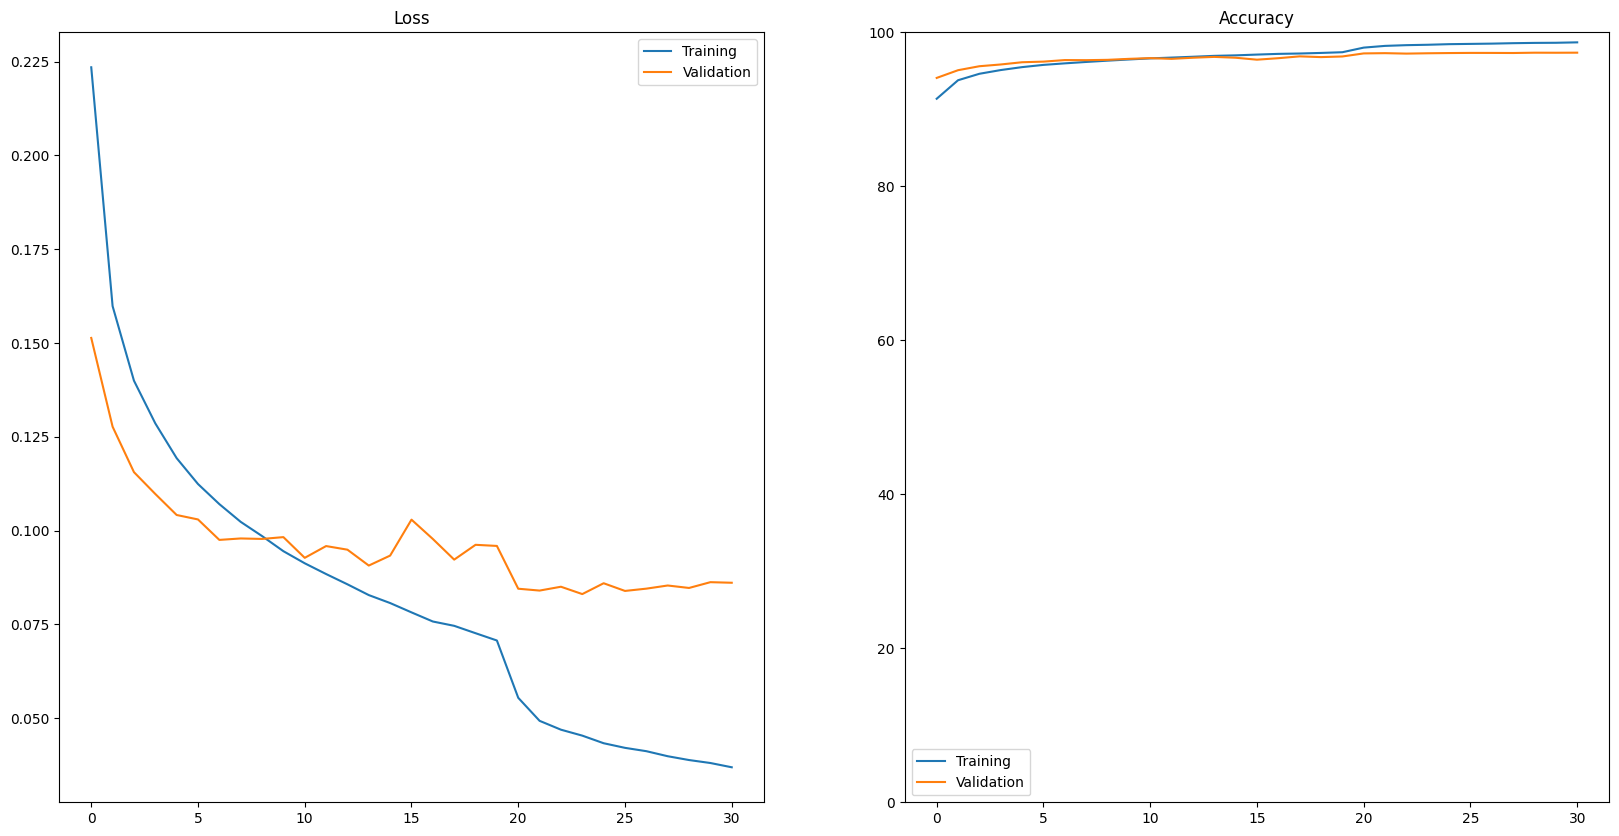

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(train_losses, label='Training') 
ax1.plot(val_losses, label='Validation')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(train_accuracies, label='Training')
ax2.plot(val_accuracies, label='Validation') 
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 100)
fig.savefig('./resamplesk_ingredients101/allergens/FineTunedDenseNet/1e-3/FineTunedDenseNet_allergens_loss_accuracy_1e-3.png')
plt.show()

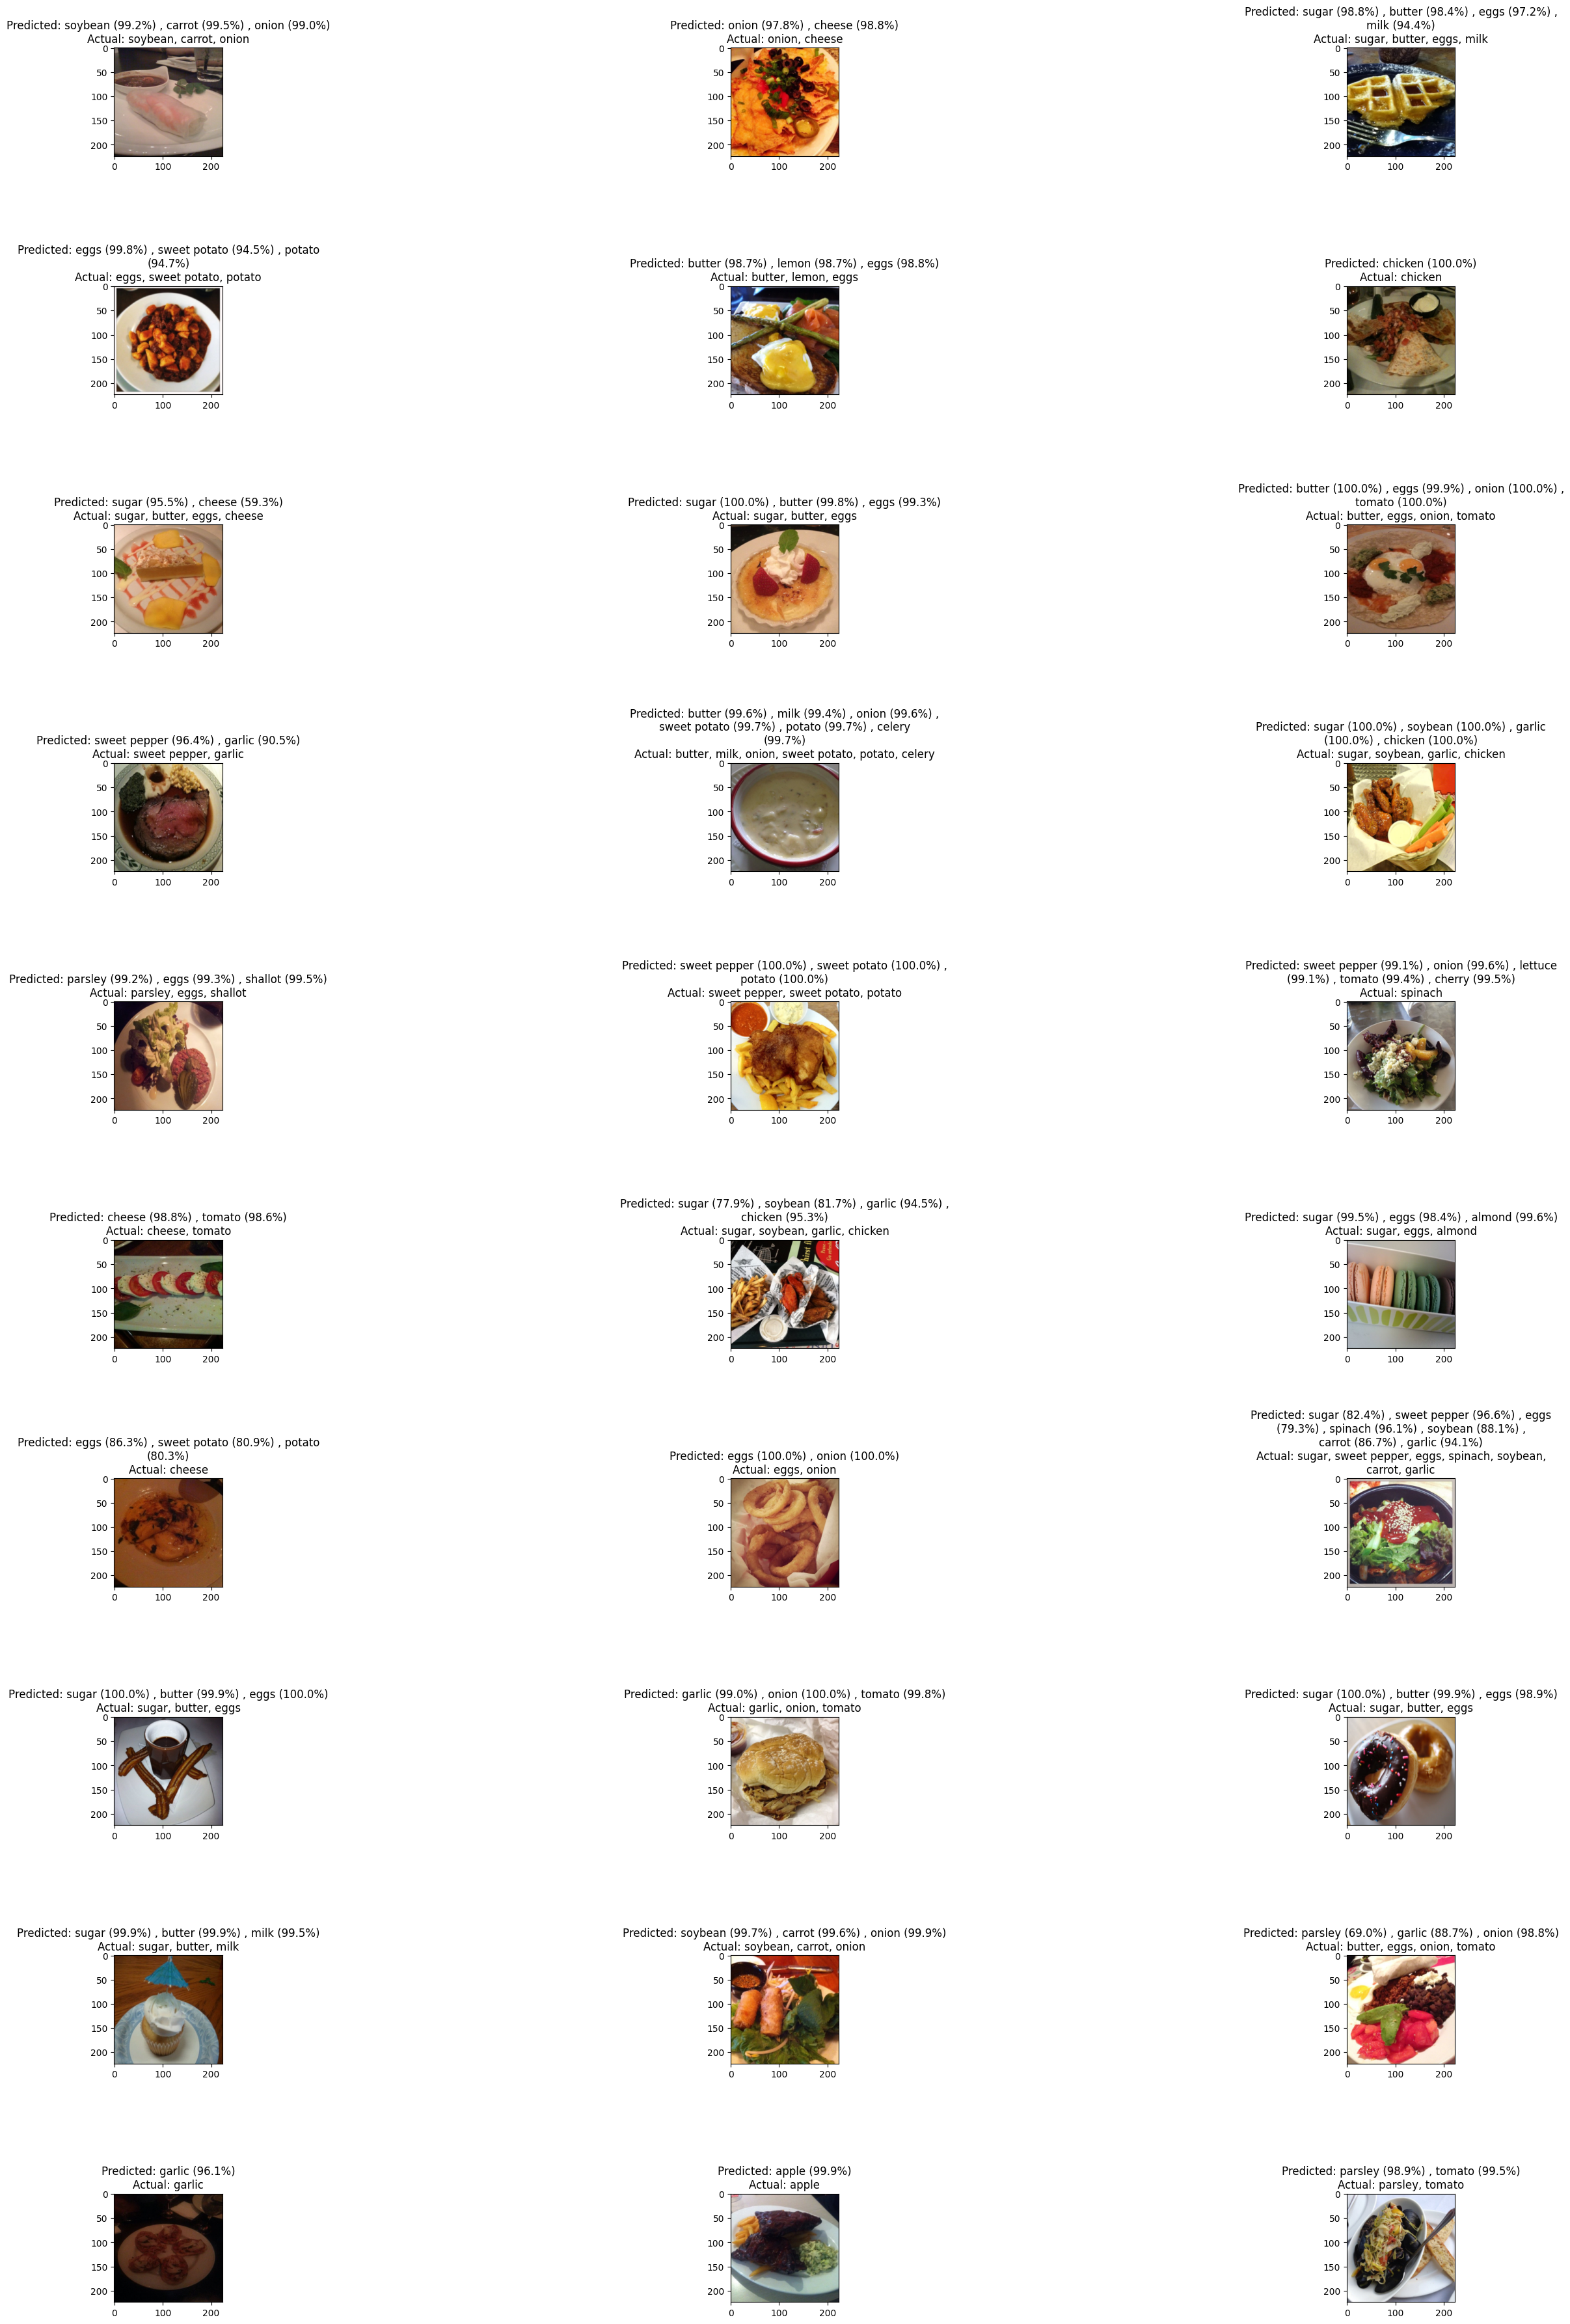

In [ ]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.float().to(mps_device), targets.to(mps_device)

# Make predictions 
outputs = model(inputs)
fig, (m_axs) = plt.subplots(10, 3, figsize=(30, 45), gridspec_kw={'hspace': 1.2, 'wspace': 1.2})
for i, c_ax in enumerate(m_axs.flatten()):
    pred_title = ', '.join(['{} ({:2.1f}%)\n'.format(allergens[j], 100 * torch.sigmoid(outputs[i, j]).item())
                            for j, v in enumerate(outputs[i])
                            if torch.sigmoid(v) > 0.5])
    wrapped_pred = '\n'.join(textwrap.wrap(pred_title, width=50))

    act_title = ', '.join(['{}'.format(allergens[j]) for j, v in enumerate(targets[i]) if v == 1.0])
    wrapped_act = '\n'.join(textwrap.wrap(act_title, width=50))
    
    img = inputs[i].permute(1, 2, 0).cpu()
    c_ax.imshow(img)
    title = "Predicted: {}\nActual: {}".format(wrapped_pred, wrapped_act)
    c_ax.set_title(title)

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc='Testing'):
        images, labels = images.to(mps_device), labels.to(mps_device)
        predictions = model(images)
        
        binary_predictions = (predictions > 0.6).cpu().numpy().astype(int)
        
        predicted_labels.extend(binary_predictions)
        true_labels.extend(labels.cpu().numpy())
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

report = classification_report(true_labels, predicted_labels, target_names=allergens, zero_division=0)
print(report)

f1score_samples = f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
f1score_macro = f1_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
f1score_weighted = f1_score(y_true=true_labels, y_pred=predicted_labels, average='weighted')
recall = recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
prec = precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
hamming = hamming_score(y_true=true_labels, y_pred=predicted_labels)


accuracy = accuracy_score(true_labels, predicted_labels)
hl = hamming_loss(true_labels, predicted_labels)
print("Accuracy: ", accuracy)
print("F1 Samples: ", f1score_samples)
print("F1 Weighted: ", f1score_weighted)
print("Hamming score: ", hamming)
print("Hamming loss: ", hl)

Testing:   0%|          | 0/790 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       sugar       0.95      0.92      0.94      7750
       apple       0.91      0.72      0.80      1000
      butter       0.93      0.87      0.90      7000
       lemon       0.91      0.82      0.86      3000
       honey       0.90      0.85      0.87      1000
sweet pepper       0.91      0.87      0.89      5250
     parsley       0.93      0.83      0.88      3000
        eggs       0.94      0.86      0.90      8500
     shallot       0.92      0.84      0.88      1500
     spinach       0.92      0.81      0.86       500
        milk       0.89      0.82      0.85      3250
     soybean       0.94      0.84      0.89      2750
      carrot       0.95      0.85      0.90      1500
      garlic       0.93      0.84      0.88      5000
       onion       0.93      0.86      0.89      7250
      cheese       0.94      0.83      0.88      5500
    lettuce        0.93      0.86      0.90      1250
      almond       0.98    

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.770930693069307
F1 Samples:  0.8389459936491387
F1 Weighted:  0.8874447631039564
Hamming score:  0.828777746346063
Hamming loss:  0.020997299729972996


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model.state_dict(), './resamplesk_ingredients101/allergens/FineTunedDenseNet/1e-3/FineTunedDenseNet_allergens_model_1e-3.pth')

In [ ]:
import pickle
loss_history = {'train_losses': train_losses, 'val_losses': val_losses}
with open('./resamplesk_ingredients101/allergens/FineTunedDenseNet/1e-3/FineTunedDenseNet_allergens_history_1e-3.pkl', 'wb') as file:
    pickle.dump(loss_history, file)